# Make_Class_Activation


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [5]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [9]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:
#history_cam_model = cam_model.fit(
#   ds_train_norm,
#    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#    validation_steps=int(ds_info.splits['test'].num_examples/16),
#    epochs=15,
#    validation_data=ds_test_norm,
#    verbose=1,
#    use_multiprocessing=True,
#)

In [11]:
import os

cam_model_path = '/content/drive/MyDrive/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [12]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

### CAM 구현하기

CAM(Class Activation Map)은 이름에서 알 수 있듯이 클래스가 활성화되는 지도이다. 일반적인 CNN은 커널 윈도우에 따라서 특성을 추출하므로 CNN 레이어를 거친 특성 맵에도 입력값의 위치정보가 유지된다. 따라서 특성 맵의 정보를 이미지 검출(detection)이나 세그멘테이션(segmentation) 등의 문제를 푸는 데 이용하기도 한다.

#### 1. GAP(Global Average Pooling)

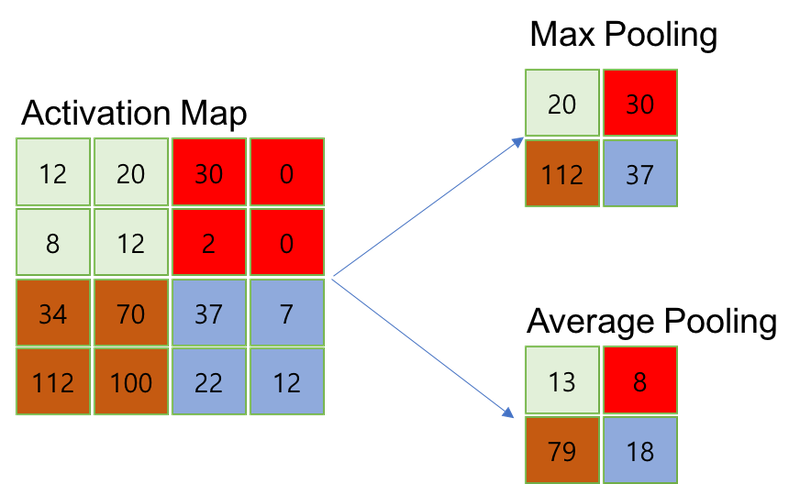

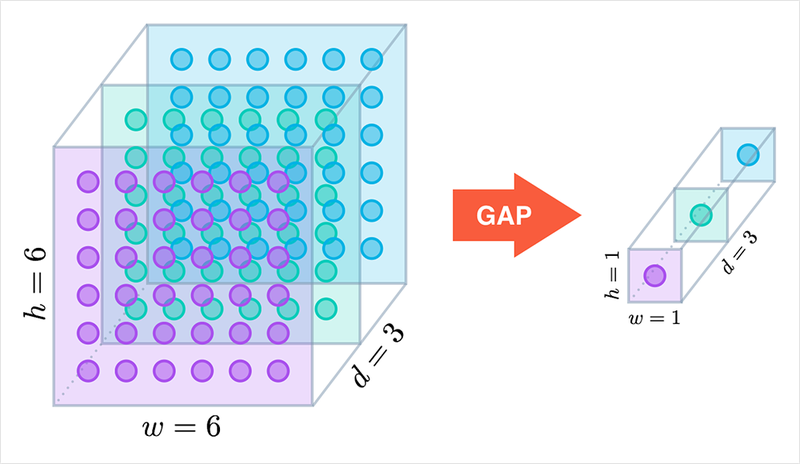

분류 모델의 마지막 부분에서 fully connected layer 대신 GAP을 사용하는 방법은 Network in Network라는 논문에서 제안되었다

일반적으로 이미지 분류에서는 여러 CNN 레이어를 거쳐 우선 특성을 추출하고, 그 특성 맵을 flattening 한 후 fully connected layer에 입력해 줌으로써 각 클래스에 따른 logit을 구하고 최종적으로 활성화 함수를 거치게 된다.

그러나 Network in Network 논문에서는 CNN 이후 fully connectd layer 대신 GAP 연산을 한다. GAP(Global Average Pooling)은 매 채널별로, average pooling을 채널의 값 전체에 global하게 적용한다. 위 그림에서 볼 수 있듯이 크기가 6x6이고 채널이 3개인 특성맵에 대해서 GAP을 수행하면 각 채널이 딱 한개의 숫자로 요약되어, 1x1 크기의 채널이 3개인 벡터를 얻게 된다. 이때 결과 벡터의 각 차원의 값은 6x6 크기의 특성 맵을 채널별로 평균을 낸 값이다. Pooling 기법에 대해서 더 알고 싶다면 위 참고자료 중 C4W1L09 Pooling Layers에서 Andrew Ng 교수님의 설명을 확인해보자.

아래 그림처럼 GAP 연산을 하고, 그 연산 결과에 소프트맥스 활성화 함수를 적용한다. 이때 마지막 CNN 레이어의 채널 수는 데이터의 클래스 수에 맞춰 각 클래스에 따른 확률을 얻을 수 있도록 했다. 원 논문에서는 이렇게 하면 특성 맵의 각 채널이 클래스별 신뢰도를 나타내게 되어 해석이 쉬울 뿐만 아니라, fully connected layer와 달리 최적화할 파라미터가 존재하지 않으므로 과적합(overfitting)을 방치할 수 있다고 설명한다.

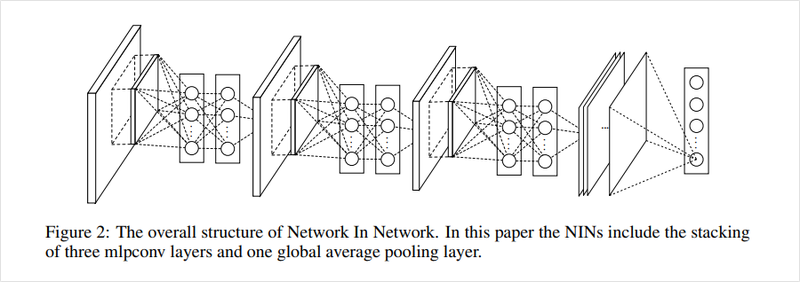

100


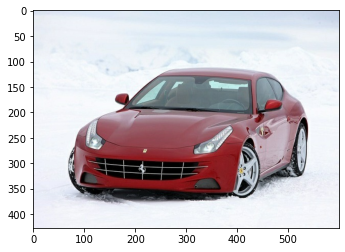

In [13]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

#### 2. CAM

CAM(Class Activation Map)은 이름에서 알 수 있듯이 클래스가 활성화되는 지도이다. 일반적인 CNN은 커널 윈도우에 따라서 특성을 추출하므로 CNN 레이어를 거친 특성 맵에도 입력값의 위치정보가 유지된다. 따라서 특성 맵의 정보를 이미지 검출(detection)이나 세그멘테이션(segmentation) 등의 문제를 푸는 데 이용하기도 한다.

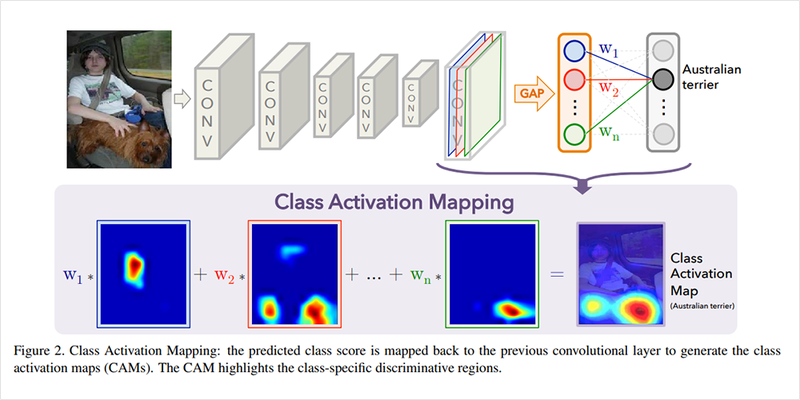

CAM을 얻을 수 있는 네트워크는 위 그림에서 볼 수 있다. 먼저 CNN 레이어를 거쳐 뽑아낸 특성 맵에 대해서 GAP을 적용한다. 그리고 이에 대해서 소프트맥스 레이어(소프트맥스 활성화 함수를 가지고 bias가 없는 fully connected layer)를 적용한다.

CNN을 거친 특성맵에서 각 클래스에 대한 정보는 결과값의 여러 채널에 걸쳐 나타나게 된다. GAP을 통해 각 채널별 정보를 요약하면 소프트맥스 레이어는 이 정보를 보내고 각 클래스에 대한 개별 채널의 중요도를 결정한다. 이렇게 클래스별로 소프트맥스 레이어를 통해 각 채널의 가중합을 구하면 각 클래스가 활성화 맵의 어떤 부분을 주로 활성화시키는지 확인할 수 있다.

이렇게 얻은 특성 맵은 CNN의 출력값 크기와 같게 된다. 이를 보간(interpolation)을 통해 적절히 원본 이미지 크기로 확대해 주면 위와 같은 CAM을 얻을 수 있다.

In [14]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [15]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

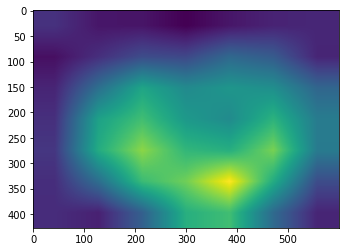

In [16]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [17]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

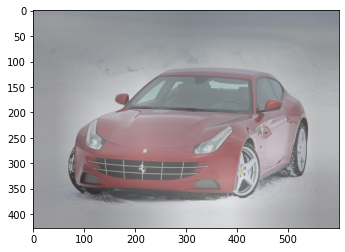

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### Grad-CAM 구현하기

이전 스텝에서 본 CAM의 경우에는 활성화 맵을 얻기 위해서 GAP을 사용하여 fk를 구하고, 그 뒤로 fully connected laywer wck를 추가로 붙어야 한다. 또 가장 마지막 CNN 레이어의 결과물만을 시각화할 수 있다.

Grad-CAM(Gradient CAM)은 CAM의 모델의 구조가 제한되는 문제를 해결하고, 다양한 모델의 구조를 해설할 수 있는 방법을 제안한다. Grad-CAM을 사용하면 CNN 기반의 네트워크는 굳이 모델 구조를 변경할 필요가 없으며, 분류 문제 외의 다른 테스크들에 유연하게 대처 할 수 있다.

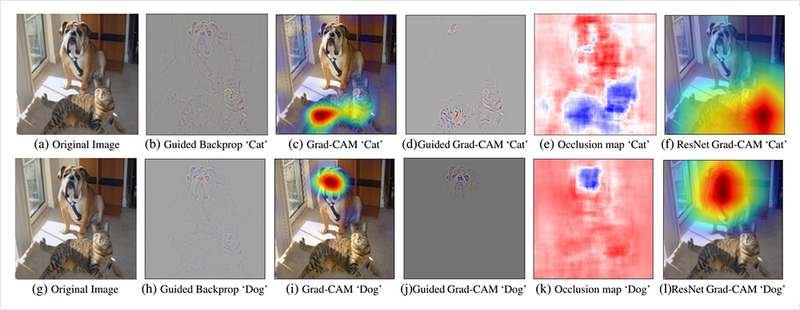

위의 이미지는 개와 고양이가 있는 이미지에 대해서 Guided Backprop, Grad-CAM, Occlussion map의 시각화를 비교하고 있다. Grad-CAM에서는 높은 분별력과 큰 dimension을 갖는 CAM을 만드는 것을 중요하게 보았다.

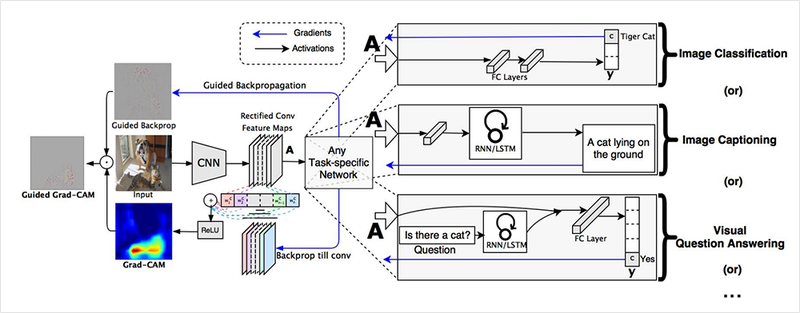

Grad-CAM의 전체적은 구조는 위와 같다. 그림의 왼쪽에서 모델의 구조를 볼 수 있다. 위에서 보았던 이미지를 입력으로 CNN을 거쳐 특성 맵을 추출하고 그 뒤로 테스크에 따라서 다양한 레이어들이 사용된다.

오른쪽의 'Image Classification'과 'Image captioning', 'Visual question Answering'은 Grad-CAM이 적용될 수 있는 다양한 컴퓨터 비전 문제들을 설명한다. Image Classification은 익히 들어왔겠지만 Image Captioning이나 Visual Question answering은 생소할 것이다. Image Captioning은 이미지에 대한 설명을 만들어내는 테스크이다. Visual question answering은 VQA라고도 불리며, 어떤 질문과 이미지가 주어졌을 때 이에 대한 답변을 내는 테스크이다.

이렇게 복잡한 모델들은 다양한 모델이 동시에 사용되기 때문에 설명하기가 매우 어렵다. Grad-CAM은 복잡한 테스크에 사용되는 모델에서도 사용될 수 있따는 점을 장점으로 내세운다.

#### 1. 약지도학습(weakly supervised learning)

딥러닝 관련 공부를 하다 보면 약지도학습과 준지도학습(semi-supervised learning)이라는 단어를 만날 수 있다. 두 개념이 실제로도 다소 혼용되기 때문에 다음과 같은 경우들로 나누어 생각해 보겠다. 아래 분류는 논문 A brief introduction to weakly supervised learning에서 정의된 것을 가져와서 정리한 것이다.

inexact supervision : 학습데이터의 라벨이 충분히 정확하게 달려있지 않은 경우, (예: 개나 고양이를 Object Detection 또는 Semantic Segmentation해야 하지만 이미지 내에 정확한 bounding box는 주어져 있지 않고 이미지가 개인지 고양인지 정보만 라벨로 달려있는 경우)

약지도학습이란 위 3가지 경우를 포괄적으로 일컫도록 사용되곤 하지만, 오늘 우리가 다루고자 하는 것은 바로 inexact supervision에 해당하는 경우이다. 일반적으로 Image Classification용 학습데이터보다는 bounding box 정보까지 정확하게 포함해야 하는 Object Detection이나 Semantic Segmentation을 위한 학습데이터가 훨씬 제작비용이 많이 든다.

아래는 Grad-CAM 논문에서 언급한 약지도학습을 통한 Object Detection과 Semantic Segmentation의 예시이다.

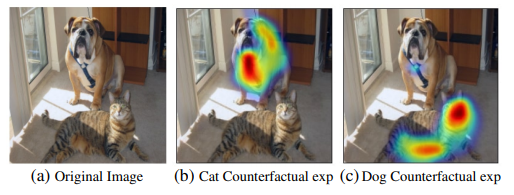

위 사진은 Grad-CAM을 통한 Counterfactual Explanation 예시이다. 아이디어는 간단한다. Grad-CAM을 통해서는 개와 고양이의 특징이 두드러지게 하는 영역의 가중치 점수를 계산할 수 있었지만, 해당 가중치 점수를 제거해 주면 Image classification 모델에서 해당 클래스에 대한 prediction이 바뀌게 될 수도 있다. 가중치 점수를 제거했을 때 prediction이 바뀌도록 하는 가중치 영역을 모으면 bounding box 라벨에 한 번도 보지 않고서도 object detection을 해낼 수 있다는 것이다.

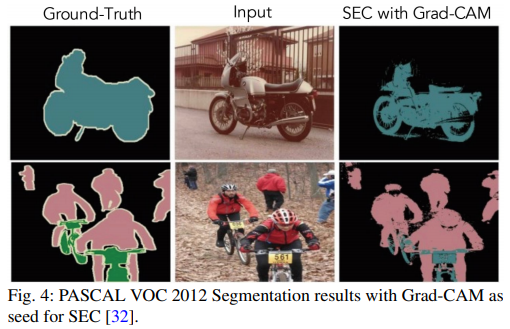

또한 Grad-CAM을 이용해서, 위와 비슷한 논리로 Semantic Segmentation도 수행 가능함을 보여준다.

또 다른 예로, 네이버랩스의 이미지기반의 차선변경 알고리즘(SLC)은 무엇을 보면서 판단을 할까?에서는 자율주행 연구에 약지도학습을 활용한 예를 확인할 수 있다.

#### 2. Adversarial Complementary Learning

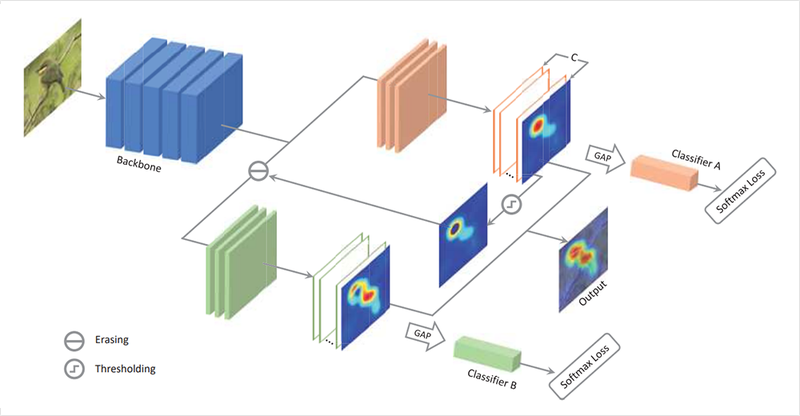

Adversarial의 뜻은 '적대적인'이다. 그렇다면 논문 제목에서 사용된 Adversarial Complementary Learning(ACoL)은 어떤 방법일까? 위 그림에서 볼 수 있듯이 ACoL은 모델의 학습에는 끝단이 두 브랜치(branch)로 나뉜다. CAM을 만들기 위해 활용했던 특성 맵을 두가지로 분리한 것이다.



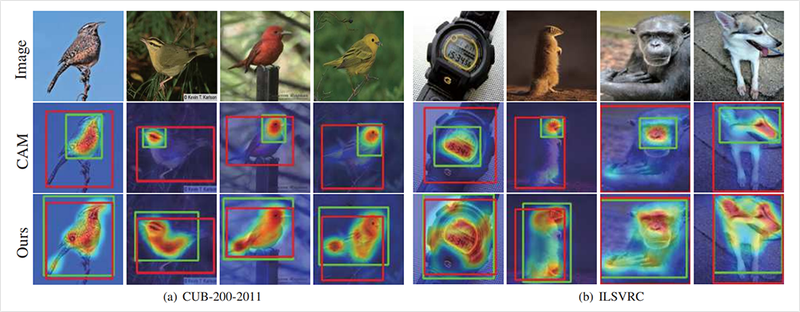

CAM과 Grad-CAM은 Weaky-supervised 방식의 Object Detection, Segmentation의 가능성을 보여 주었다. 그러나 이들 방식에는 한 가지 문제가 있다. CAM을 통해 본 활성화 맵을 보면 가장자리보다는 특징이 주로 나타나는 위치에 중점적으로 활성화되는 모습을 볼 수 있다.

하지만 물체 검출 (Object detection)은 새의 부리나 동물의 눈, 시계의 숫자와 같이 부분적 특성이 아닌 물체의 전체적은 형태와 윤곽을 정확하게 구분해 내는 것이 중요하다. CAM 모델이 특정 부위에 집중해 학습하는 것을 막기 위해서 ACoL은 브랜치를 두가지로 두어 너무 높은 점수를 지워줌으로써 주변의 특성 또한 반영하도록 했다. 이러한 과정을 논문에서는 Adversial, 즉 적대적인 학습방법이라고 한다.

ACoL의 구조를 살펴보면 먼저 위쪽 주황색 브랜치를 거친다. 특성 맵은 GAP을 거쳐 CAM에서 보았던 소프트맥스 레이어인 Classifier A를 거치게 된다. 이 브랜치는 loss로 학습된다.

ACoL은 여기서 얻어진 활성화 맵을 적대적인 방법으로 사용한다. 일정 값 이상 활성화된 활성화 맵을 지우도록 하는 것이다. Classifier A는 쉽게 전체적인 이미지를 보고 클래스를 판별할 수 있는 반면에 Classifier B는 A의 CAM에서 크게 활성화된 영역을 지운 활성화 맵에서 분류를 해야 하기 때문에 더 어려운 문제를 푸는 것으로 볼 수 있다.

이렇게 두가지 Classifier A와 Classfier B를 학습시킴으로써 더 넓은 영역을 판별의 근거로 삼을 수 있다. 이 과정을 통해서 모델은 쉽게 맞출 수 있는 샘플을 어렵게 다시 한 번 학습을 하는 Adversarial Complementary Learning 과정을 거치게 된다.

결과적으로 위 그림에서는 기존 CAM이 활성화되는 부분과 달리 ACoL은 물체의 전반적은 영역으로 CAM이 활성화되는 효과를 확인할 수 있다.

#### 1x1 Conv

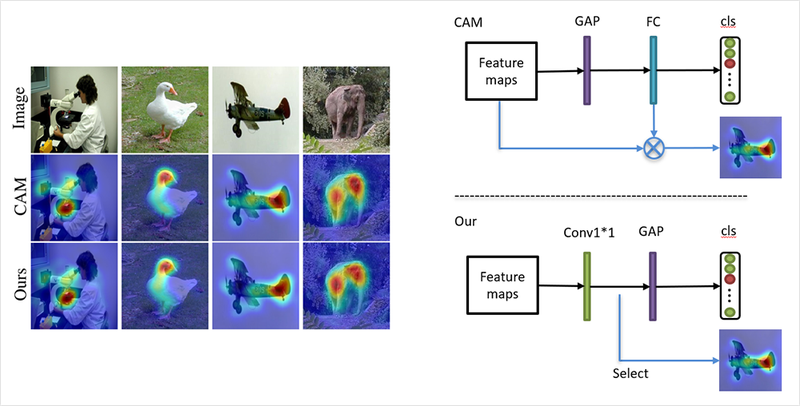

CAM에서는 CAM을 얻기 위해서 대상이 되는 네트워크에 feed forward를 하고 활성화 맵과 가중치 계산을 다시 해주어야 한다. 이 과정은 관찰하고자 하는 분류 모델의 feed forward와 별개의 작업이므로, 물체 검출을 위한 모델로 사용하기 위해서는 모델의 feed forward 외 별도로 연산을 해주어야 하는 단점이 있다.

ACoL 논문은 이를 개선하기 위해서 커널 사이즈는 1x1, 출력 채널의 개수는 분류하고자 하는 클래스 개수를 가진 컨볼루션 레이어를 특성맵에 사용하고 여기에 GAP을 적용하여 Network in Network에서 본 구조와 유사한 방식을 사용하고 있다. 여기서 컨볼루션 레이어의 출력값은 곧바로 활성화 맵이 된다. 이렇게 구해진 활성화 맵과 CAM을 비교한 결과를 위 그림의 왼쪽에서 볼 수 있다.

141


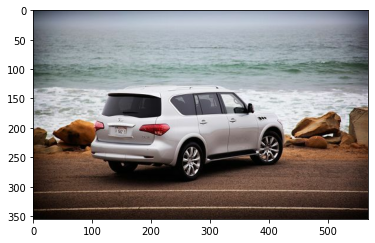

In [19]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [20]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

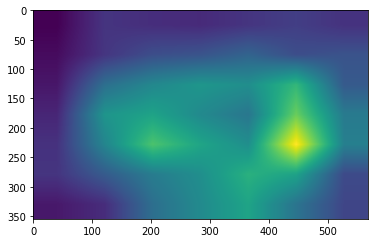

In [21]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

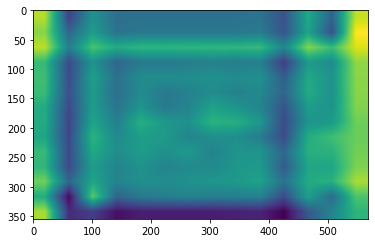

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

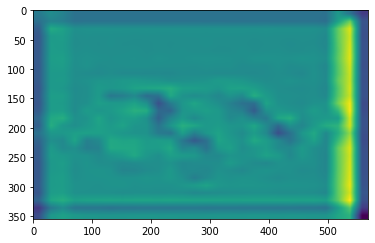

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

### 바운딩 박스 구하는 함수

In [24]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [25]:
rect = get_bbox(cam_image)
rect

array([[  0,   0],
       [599,   0],
       [599, 426],
       [  0, 426]])

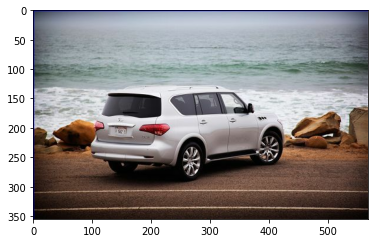

In [26]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU 구하기

In [27]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [28]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### Report

#### 원본 사진

116


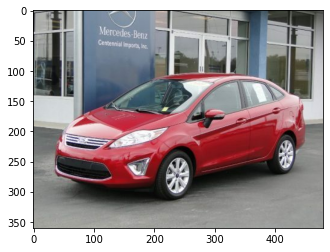

In [29]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

#### CAM 성능

In [30]:
cam_image = generate_cam(cam_model, item)

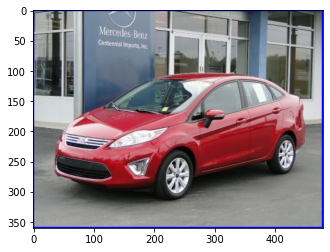

In [31]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [32]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['bbox'])

0.5092434508188755

#### Grad_CAM 성능

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)

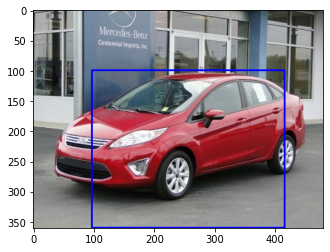

In [34]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect_g],0,(0,0,255),2)
plt.imshow(image)

In [35]:
pred_bbox = rect_to_minmax(rect_g, item['image'])
get_iou(pred_bbox, item['bbox'])

0.6471213202651155

### 회고

이론은 이해하고 돌렸으나, 성능 과정에서 결과값이 아쉽다.